# Машинное обучение 2020, часть 2, семинар 5. Тематическое моделирование

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Постановка задачи

Дано:
* $W$ - конечное множество термов
* $D$ - конечное множество документов
* $n_{dw}$ - частоты слов $w$ в документах $d$

Найти:
* вероятностную тематическую модель
$$
p(w|d) = \sum\limits_{t\in T} p(w|d, t)p(t|d) = \sum\limits_{t \in T}\phi_{wt}\theta_{dt}
$$

## Датасет

Классический датасет для изучения тематического моделирования - это 20 Newsgroup Dataset: http://qwone.com/~jason/20Newsgroups/. Для наших целей хватит и его части.

In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


content  ...            target_names
10  From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: W...  ...         rec.motorcycles
21  From: leunggm@odin.control.utoronto.ca (Gary Leung)\nSubject: Re: NHL Team Captains\nOrganizatio...  ...        rec.sport.hockey
28  From: jonh@david.wheaton.edu (Jonathan Hayward)\nSubject: Re: Pantheism & Environmentalism\nOrga...  ...  soc.religion.christian
33  From: ayr1@cunixa.cc.columbia.edu (Amir Y Rosenblatt)\nSubject: Re: Israeli Expansion-lust\nNntp...  ...   talk.politics.mideast
35  From: dchhabra@stpl.ists.ca (Deepak Chhabra)\nSubject: Re: Goalie masks\nNntp-Posting-Host: stpl...  ...        rec.sport.hockey

[5 rows x 3 columns]

Удалим е-мэйлы и вообще почистим наши новости. Кроме этого, разделим наши новости на токены:

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

Создадим часто встречающиеся биграммы, триграммы и лемматизируем токены:

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## LDA

И, наконец-то, создадим LDA-модель! А также обучим и выведем слова, описывающие темы:

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.012*"state" + 0.012*"israeli" + 0.011*"people" + 0.011*"kill" + '
  '0.009*"attack" + 0.009*"government" + 0.008*"war" + 0.007*"turkish" + '
  '0.006*"soldier" + 0.006*"greek"'),
 (1,
  '0.020*"game" + 0.018*"bike" + 0.017*"write" + 0.012*"article" + '
  '0.009*"rider" + 0.008*"list" + 0.008*"ride" + 0.007*"score" + '
  '0.006*"motorcycle" + 0.006*"helmet"'),
 (2,
  '0.017*"team" + 0.015*"year" + 0.012*"time" + 0.011*"write" + 0.009*"well" + '
  '0.009*"first" + 0.009*"play" + 0.008*"look" + 0.008*"help" + 0.008*"name"'),
 (3,
  '0.014*"people" + 0.012*"write" + 0.010*"believe" + 0.008*"reason" + '
  '0.007*"evidence" + 0.006*"question" + 0.006*"thing" + 0.006*"article" + '
  '0.006*"claim" + 0.005*"faith"')]


Для каждой новости вычислим, какая тема в ней доминирует и насколько:

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  ...                                               Text
0            0  ...  [summary, worth, expire, keyword, ducati, gts,...
1            1  ...  [group, article, write, course, time, prior, t...
2            2  ...  [write, new, group, maybe, cover, already, cur...
3            3  ...  [article, write, article, write, article, writ...
4            4  ...  [goalie_mask, organization, ist, article, writ...
5            5  ...  [bmw_moa_member, read, internet, access, syste...
6            6  ...  [require, organization, article, write, articl...
7            7  ...  [looking, movie, bike, university, latech, sum...
8            8  ...  [organization, university, follow, thread, tal...
9            9  ...  [day, night, round, male, inhabitant, article,...

[10 rows x 5 columns]

Для каждой темы выберем наиболее характеризующее её предложение:

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  [armenian, genocide, people, article, write, ranada, ermeniler, boyle, icin, bulunan, oldurmuler...
1        1.0  ...  [hockey, draft, price, list, price, list, week, buy, team, player, pit, det, tor, pit, pit, tor,...
2        2.0  ...  [article, cire, write, write, write, captain, ever, traded_resigne, stripe, title, season, appre...
3        3.0  ...  [article, write, affirm, absolute, scripture, believe, truth, reveal, truth, word, therefore, ho...

[4 rows x 4 columns]

Распределение количества слов по документам:

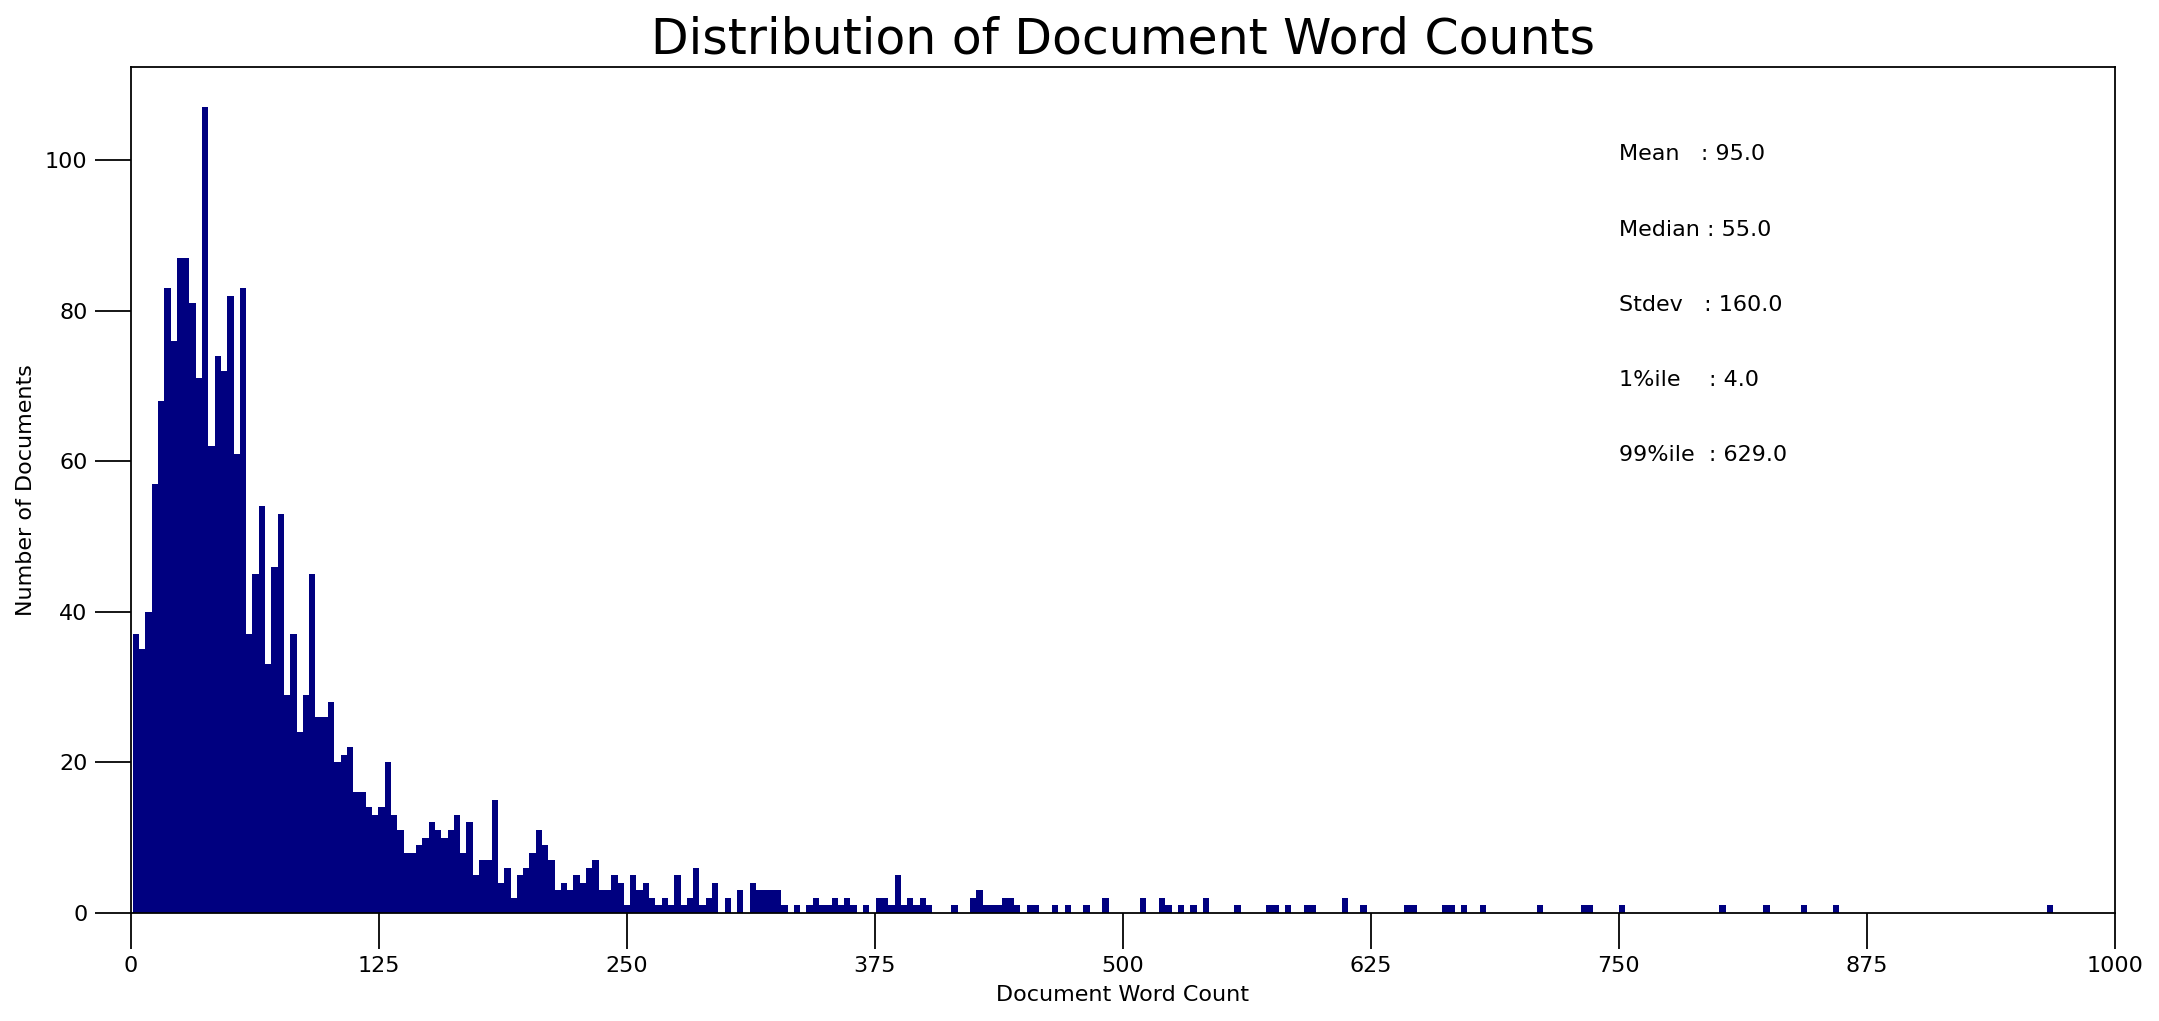

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

И распределение количества слов в документах по темам: 

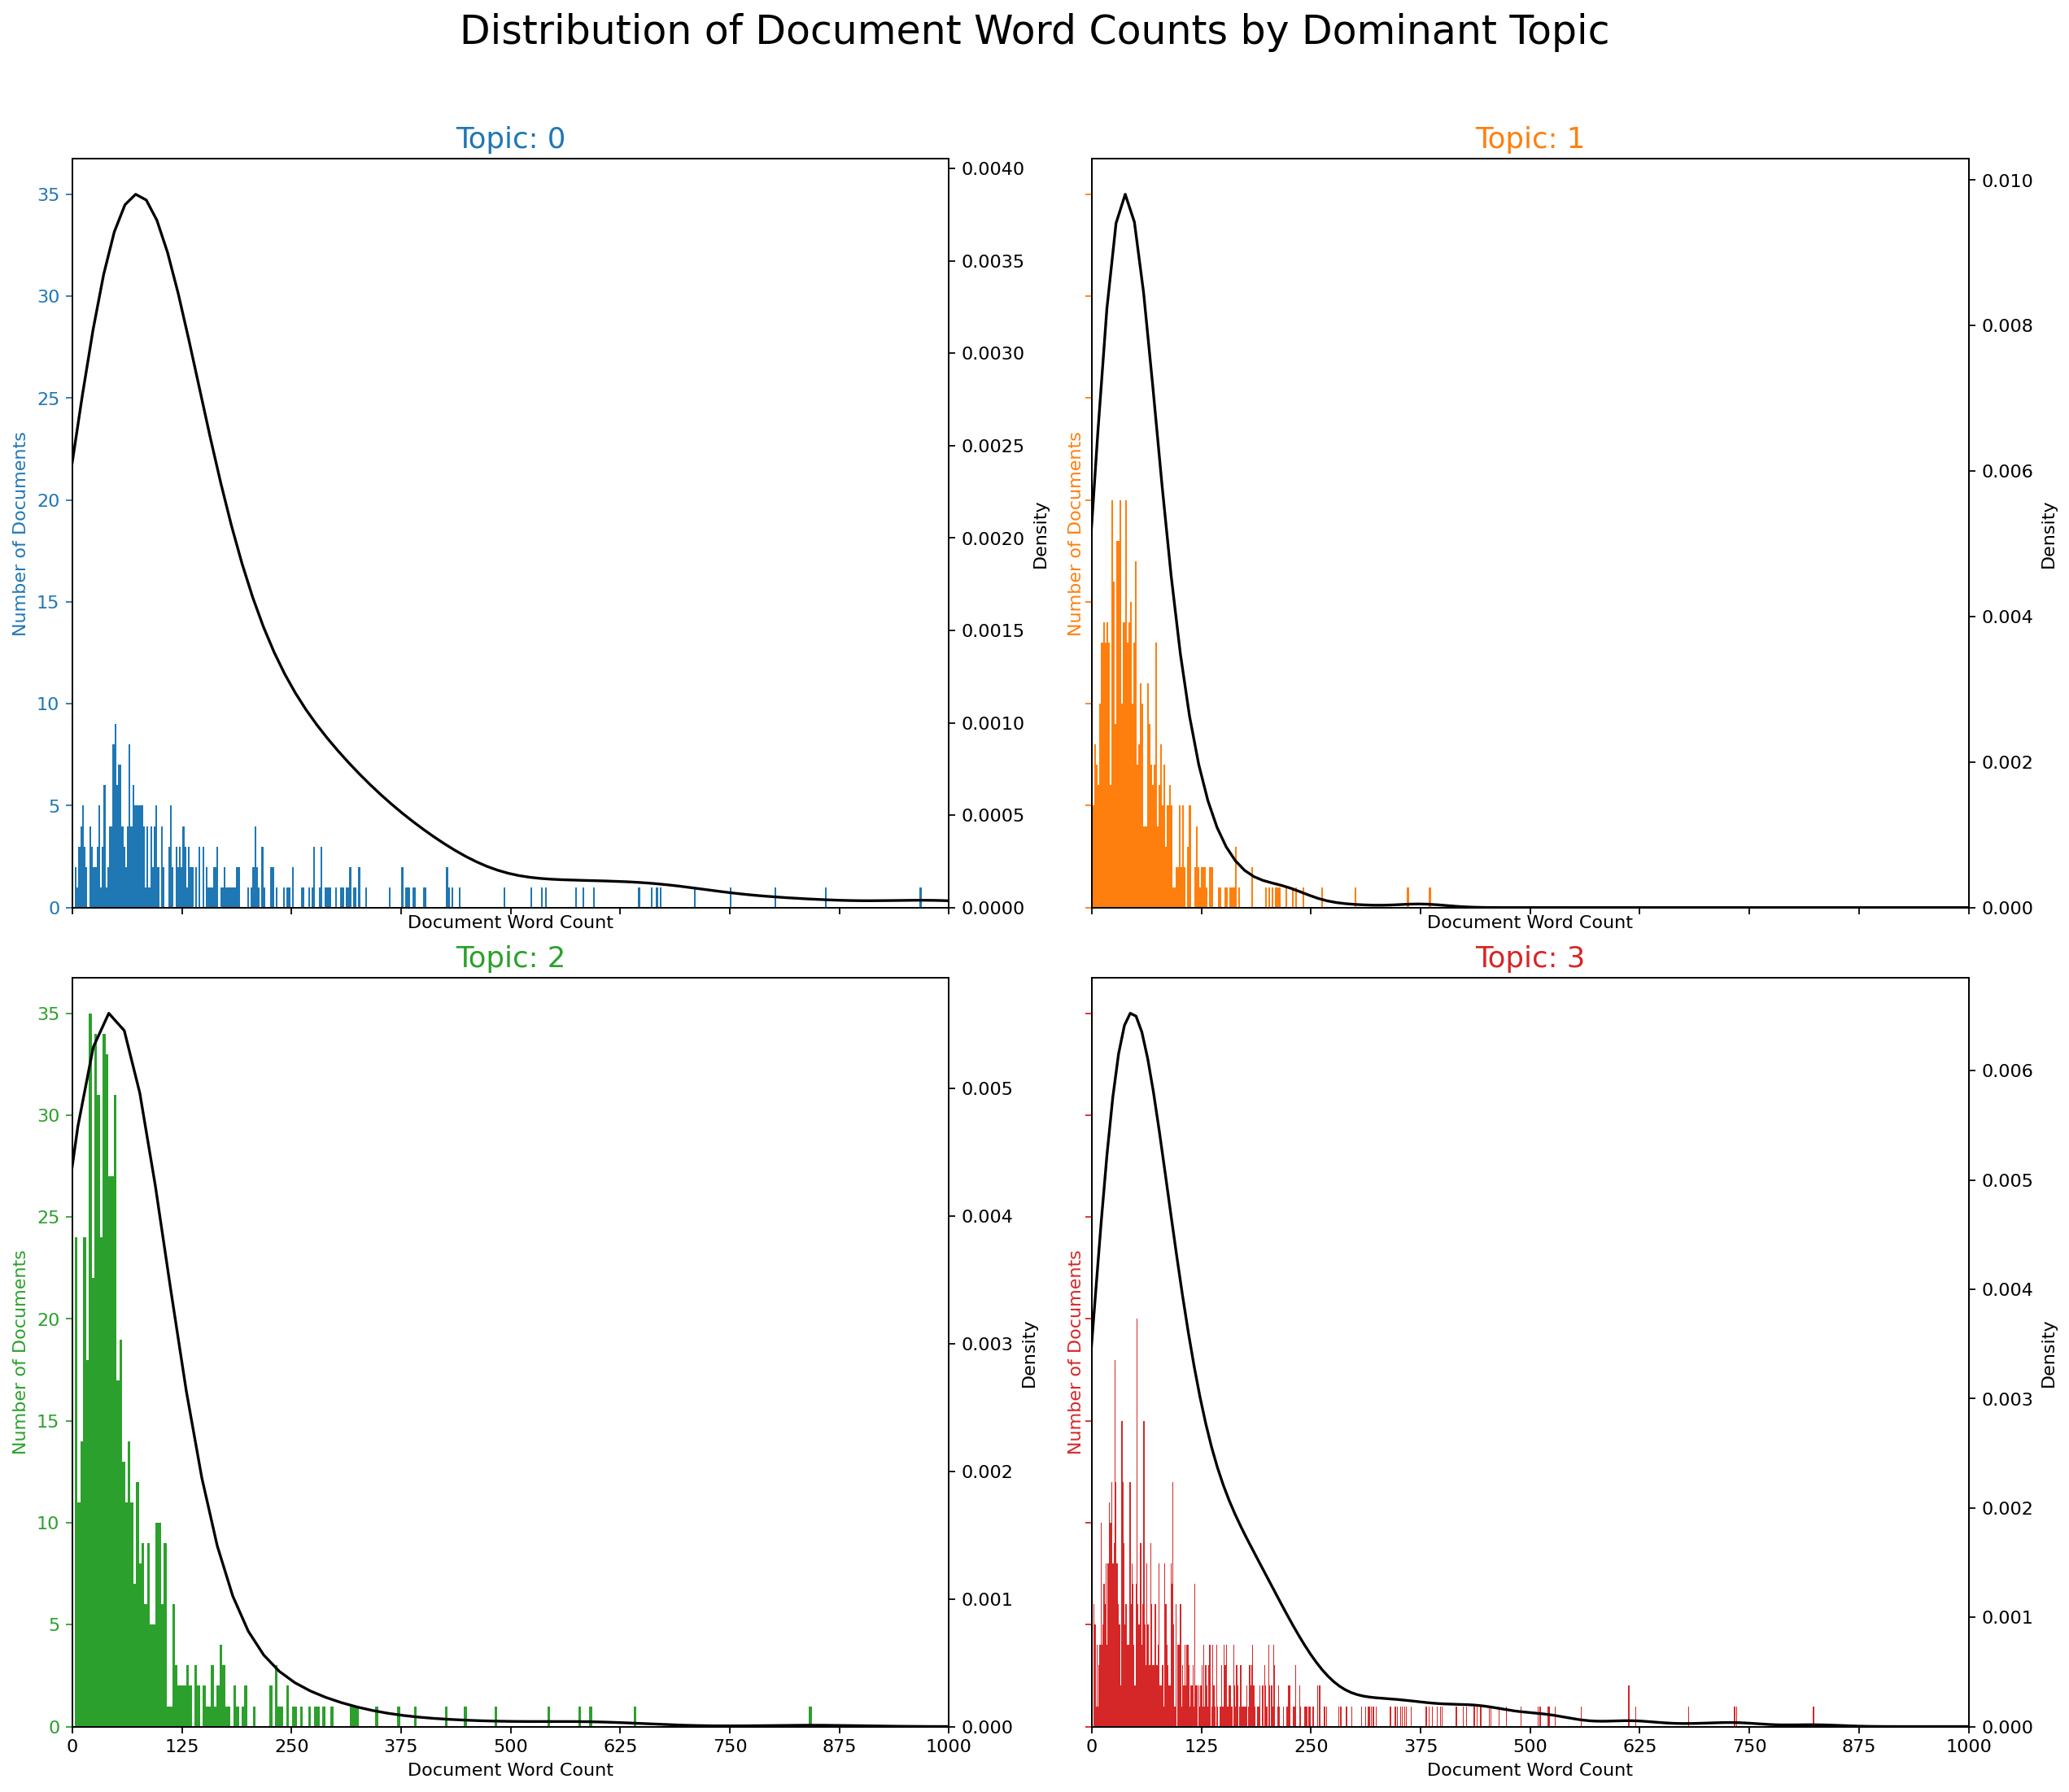

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

Ну и красивые облака слов :)

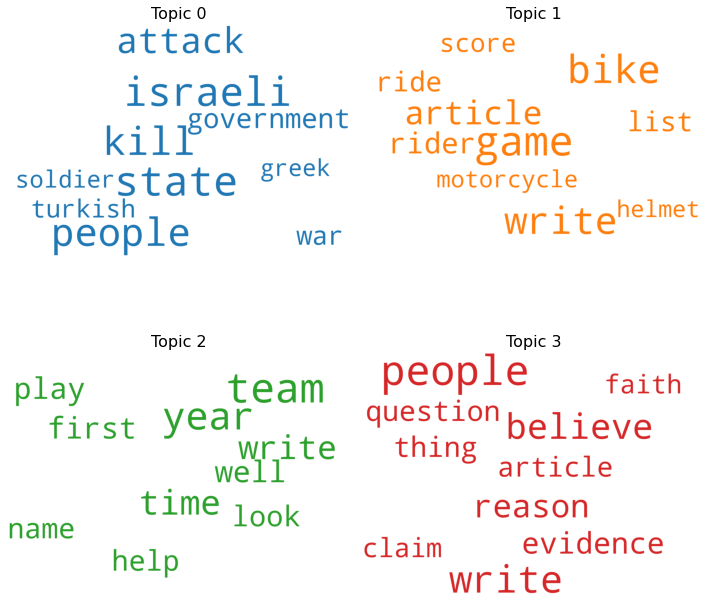

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Нарисуем на одном графике для слов их частоту и важность в теме:

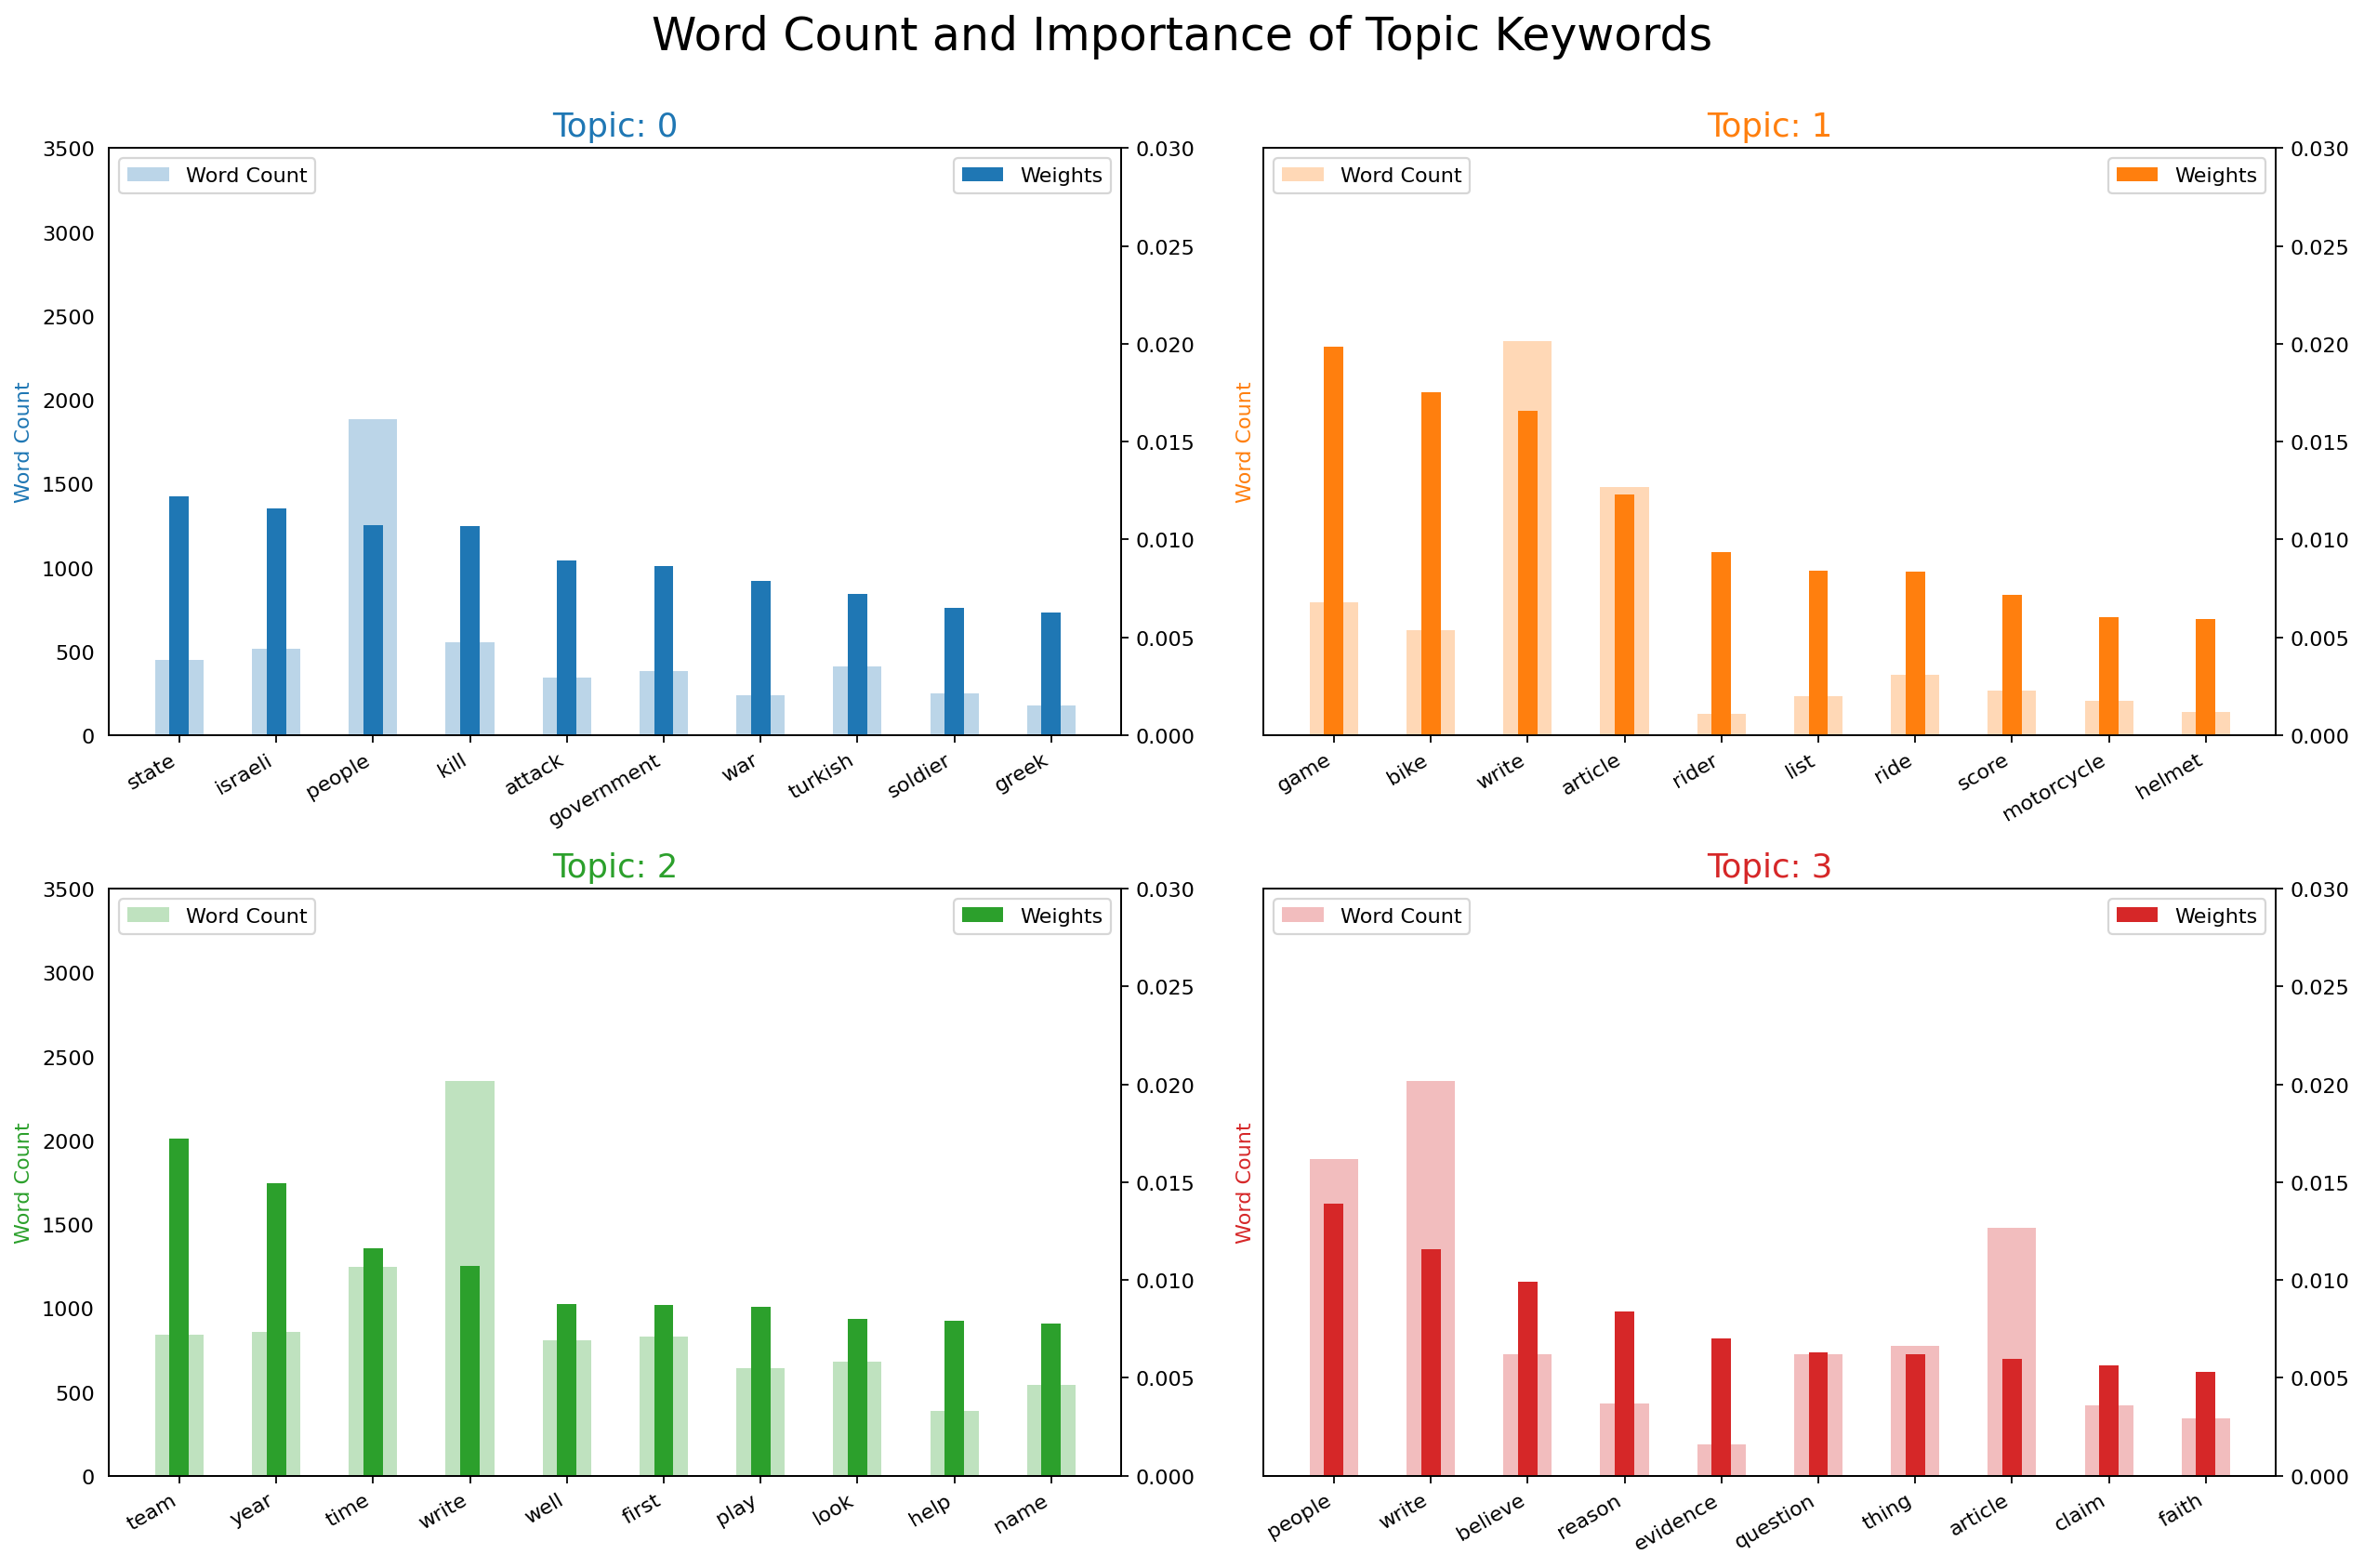

In [120]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        # print(word, counter[word])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Также можно визуализировать каждую новость с указанием того, к какой теме относится какое слово:

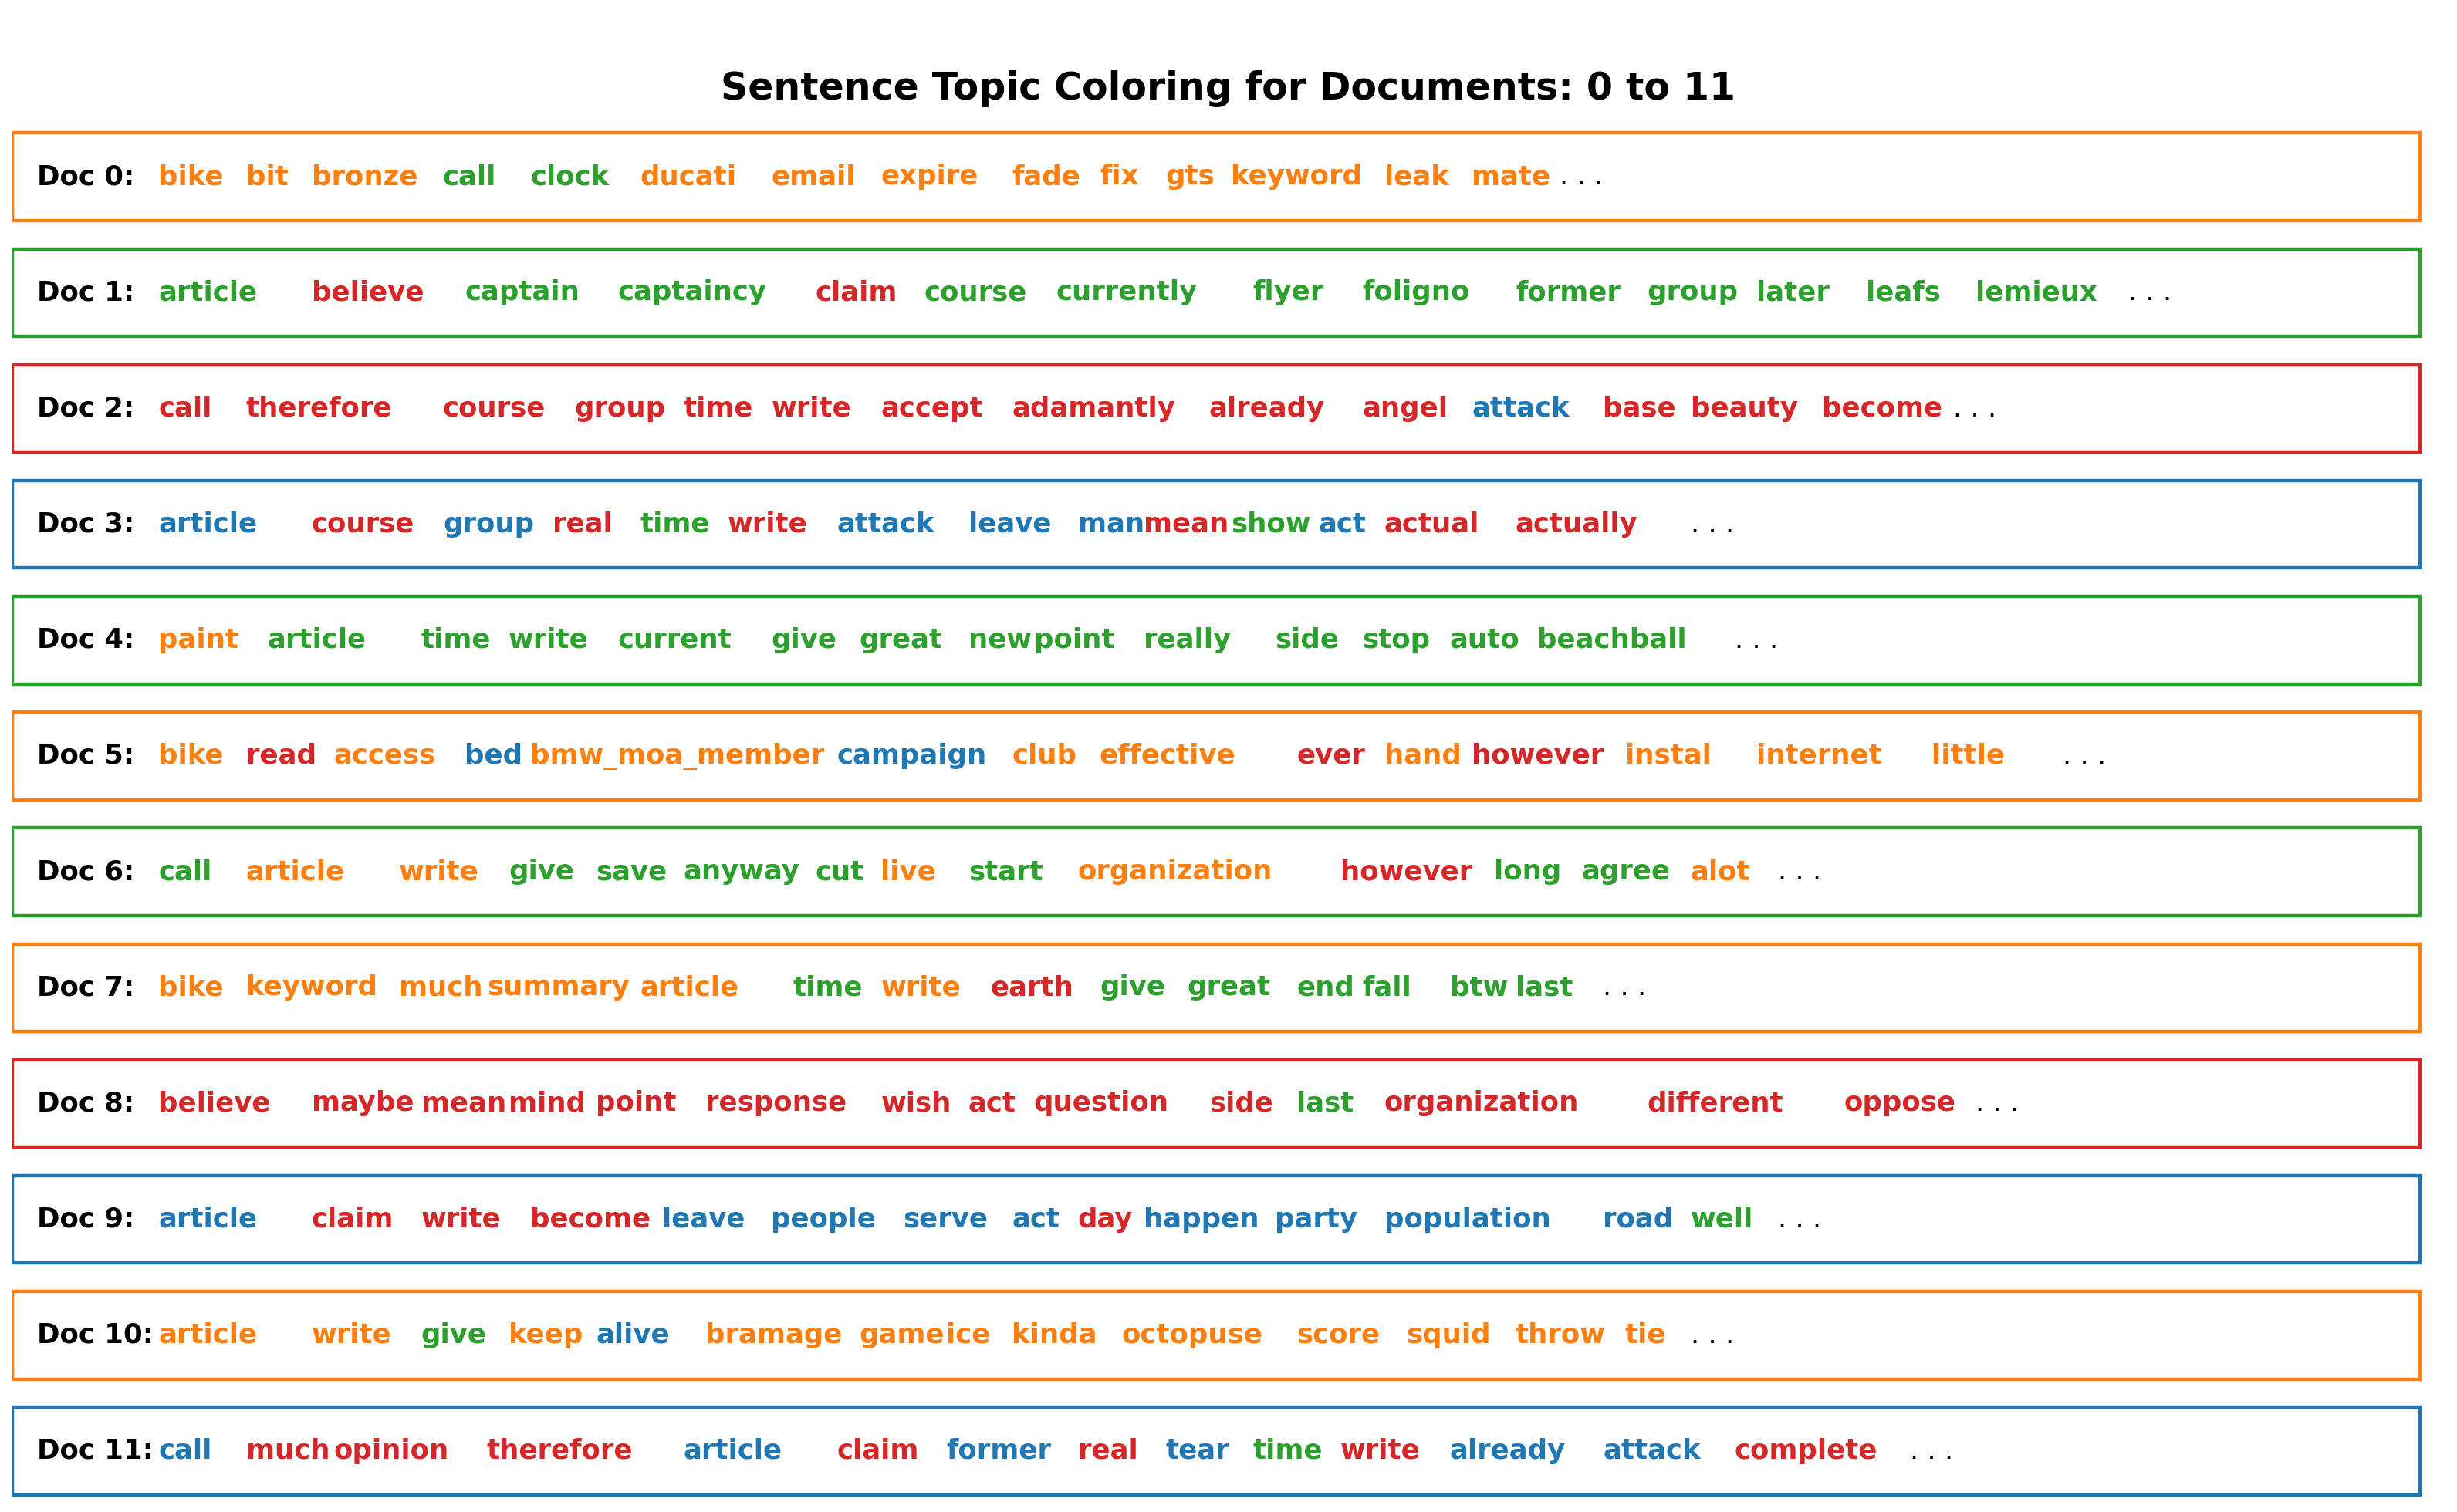

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

И самое главное!

**Задача 1 (1 балл)**. Выберите какие-нибудь топ-5 самых часто встречающихся слов и топ-5 самых редко встречающихся слов (min 5 встречаний). Для каждого из них выведите распределение количества документов по темам, в которых они встречаются.

In [ ]:
from collections import Counter

data_flat = [w for w_list in data_ready for w in w_list]
print(data_flat[:10])
counter = Counter(data_flat)

['summary', 'worth', 'expire', 'keyword', 'ducati', 'gts', 'much', 'ducati', 'model', 'clock']


In [ ]:
most_common = counter.most_common(6)
print(f'The most common words: {most_common}')

The most common words: [('write', 2351), ('people', 1886), ('article', 1477), ('time', 1244), ('give', 918), ('year', 858)]


In [ ]:
least_common = {k: v for k, v in counter.items() if v == 5}
least_common = list(least_common.items())[:6]
print(f'The least common words: {least_common}')

The least common words: [('predate', 5), ('tent', 5), ('checker', 5), ('scum', 5), ('amazed', 5), ('fame', 5)]


In [126]:
import matplotlib.pyplot as plt

def plot_distribution(word, count, df_dominant_topic, ax):
  mask = [word in cell['Text'] for i, cell in df_dominant_topic.iterrows()]
  themes = df_dominant_topic[mask]
  ax.hist(themes['Dominant_Topic'].astype(int))
  ax.set_xticks(range(4))
  ax.set_title(f'{word}, total={count}')

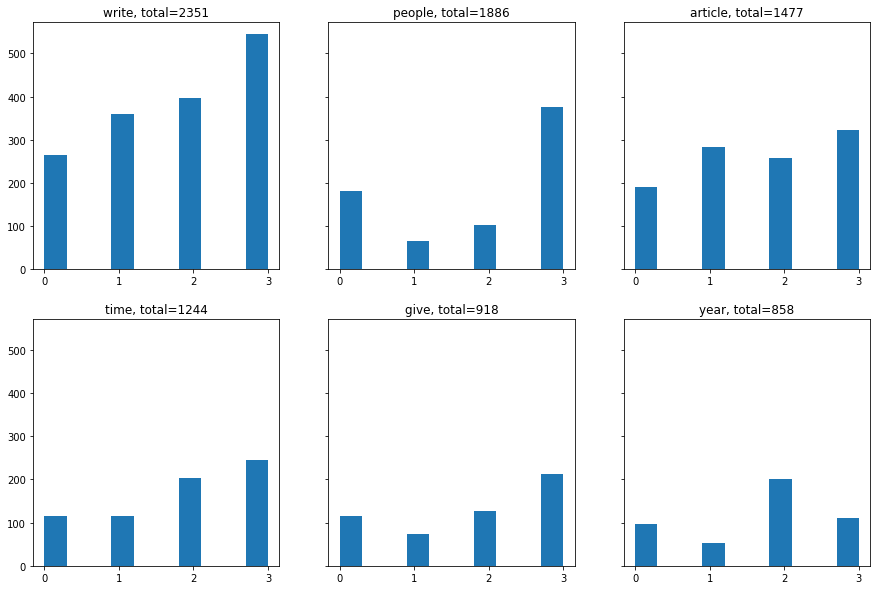

In [127]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10), sharey=True)
i = 0
for word, count in most_common:
  plot_distribution(word, count, df_dominant_topic, axes[i // 3, i % 3])
  i += 1

plt.show()

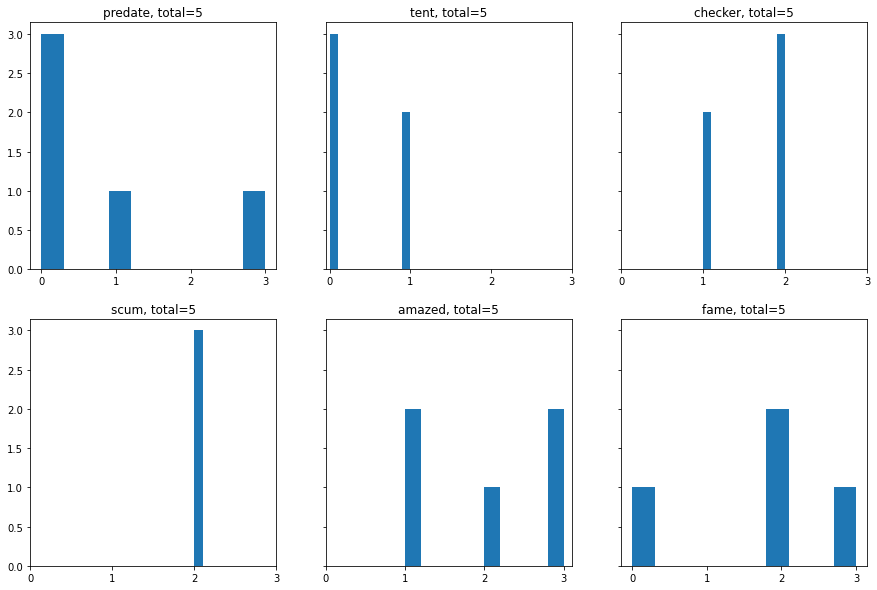

In [128]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10), sharey=True)
i = 0
for word, count in least_common:
  plot_distribution(word, count, df_dominant_topic, axes[i // 3, i % 3])
  i += 1

plt.show()

Так как мы брали, чтобы слово встречалось как минимум 5 раз, а не как минимум в 5ти документах, то получили, что для слова 'scum' у нас найдено только три документа по теме 2.

**Задача 2 (1 балл)**. Попробуйте построить тематическую модель по двум темам на выбранных нами документах и посмотрите, получится ли что-то осознанное. Аналогично, на трёх темах и на семи темах.

In [141]:
def create_model(num_topics):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

  print('Model:')
  pprint(lda_model.print_topics())
  return lda_model

In [147]:
def get_topics(model, corpus, data):
  df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data)

  # Format
  df_dominant_topic = df_topic_sents_keywords.reset_index()
  df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
  return df_dominant_topic, df_topic_sents_keywords

In [146]:
def get_most_relevant_text(df_topic_sents_keywords):
  sent_topics_sorteddf_mallet = pd.DataFrame()
  sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

  for i, grp in sent_topics_outdf_grpd:
      sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                              grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                              axis=0)
    
  sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
  sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
  return sent_topics_sorteddf_mallet

In [151]:
lda_model_2 = create_model(2)
df_dominant_topic_2, df_topic_sents_keywords_2 = get_topics(lda_model_2, corpus, data_ready)
df_relevant_text_2 = get_most_relevant_text(df_topic_sents_keywords_2)

Model:
[(0,
  '0.012*"people" + 0.009*"write" + 0.006*"believe" + 0.005*"article" + '
  '0.005*"reason" + 0.005*"time" + 0.005*"give" + 0.004*"evidence" + '
  '0.004*"thing" + 0.004*"tell"'),
 (1,
  '0.013*"team" + 0.013*"write" + 0.010*"game" + 0.009*"article" + '
  '0.008*"year" + 0.008*"bike" + 0.007*"play" + 0.006*"time" + 0.006*"player" '
  '+ 0.005*"hockey"')]


In [152]:
df_dominant_topic_2.head()

Document_No  ...                                                                                                 Text
0            0  ...  [summary, worth, expire, keyword, ducati, gts, much, ducati, model, clock, paint, bronze, fade, ...
1            1  ...  [group, article, write, course, time, prior, trade, currently, penguin, former, captain, real, c...
2            2  ...  [write, new, group, maybe, cover, already, current, emphasis, environment, turn, unintentionally...
3            3  ...  [article, write, article, write, article, write, imho, really, matter, start, individual, battle...
4            4  ...  [goalie_mask, organization, ist, article, write, vote, city, side, bunch, bee, look, really, sha...

[5 rows x 5 columns]

In [153]:
df_relevant_text_2.head(10)

Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  [write, response, clear, much, faq, paul, comment, esteem, day, rom, probably, word, high, prior...
1        1.0  ...  [final, season, chl, stuff, originator, final, stat, season, league, local, intrest, control, da...

[2 rows x 4 columns]

Видим, что одна тема у нас связана со спортом(хоккей и байки), а вторая - с религией и, видимо, доказательствами существования высших сил.

In [154]:
lda_model_3 = create_model(3)
df_dominant_topic_3, df_topic_sents_keywords_3 = get_topics(lda_model_3, corpus, data_ready)
df_relevant_text_3 = get_most_relevant_text(df_topic_sents_keywords_3)

Model:
[(0,
  '0.010*"israeli" + 0.009*"kill" + 0.009*"people" + 0.008*"attack" + '
  '0.008*"government" + 0.007*"war" + 0.007*"state" + 0.006*"turkish" + '
  '0.006*"soldier" + 0.005*"force"'),
 (1,
  '0.015*"team" + 0.013*"write" + 0.012*"game" + 0.009*"year" + 0.009*"bike" + '
  '0.009*"article" + 0.008*"play" + 0.007*"player" + 0.006*"time" + '
  '0.006*"hockey"'),
 (2,
  '0.013*"people" + 0.012*"write" + 0.008*"believe" + 0.007*"reason" + '
  '0.007*"article" + 0.006*"thing" + 0.006*"evidence" + 0.005*"question" + '
  '0.005*"time" + 0.005*"give"')]


In [155]:
df_dominant_topic_3.head()

Document_No  ...                                                                                                 Text
0            0  ...  [summary, worth, expire, keyword, ducati, gts, much, ducati, model, clock, paint, bronze, fade, ...
1            1  ...  [group, article, write, course, time, prior, trade, currently, penguin, former, captain, real, c...
2            2  ...  [write, new, group, maybe, cover, already, current, emphasis, environment, turn, unintentionally...
3            3  ...  [article, write, article, write, article, write, imho, really, matter, start, individual, battle...
4            4  ...  [goalie_mask, organization, ist, article, write, vote, city, side, bunch, bee, look, really, sha...

[5 rows x 5 columns]

In [156]:
df_relevant_text_3.head(10)

Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  [armenian, genocide, people, article, write, ranada, ermeniler, boyle, icin, bulunan, oldurmuler...
1        1.0  ...  [result, game, play, organization, keyword, boxscore, nhl, result, game, play, standing, adam, c...
2        2.0  ...  [article, write, priority, direct, word, begin, weak, faith, count, weak, faith, count, weak, fa...

[3 rows x 4 columns]

Результаты на трех темах говорят, что у нас есть тема 0 - связанная с агрессией и войнами, а также предыдущие две темы: 1 - спорт, 2 - вера.

In [157]:
lda_model_7 = create_model(7)
df_dominant_topic_7, df_topic_sents_keywords_7 = get_topics(lda_model_7, corpus, data_ready)
df_relevant_text_7 = get_most_relevant_text(df_topic_sents_keywords_7)

Model:
[(0,
  '0.051*"team" + 0.026*"play" + 0.022*"player" + 0.020*"hockey" + '
  '0.016*"playoff" + 0.015*"speak" + 0.014*"pen" + 0.013*"goal" + '
  '0.010*"season" + 0.010*"coach"'),
 (1,
  '0.034*"game" + 0.024*"year" + 0.016*"opinion" + 0.015*"next" + 0.014*"wing" '
  '+ 0.013*"list" + 0.011*"much" + 0.011*"score" + 0.009*"motorcycle" + '
  '0.009*"helmet"'),
 (2,
  '0.049*"write" + 0.031*"article" + 0.020*"time" + 0.017*"first" + '
  '0.014*"well" + 0.011*"people" + 0.010*"look" + 0.010*"day" + 0.010*"name" + '
  '0.010*"really"'),
 (3,
  '0.020*"believe" + 0.016*"reason" + 0.016*"evidence" + 0.012*"faith" + '
  '0.010*"claim" + 0.010*"kill" + 0.009*"attack" + 0.009*"question" + '
  '0.009*"jewish" + 0.009*"law"'),
 (4,
  '0.016*"thing" + 0.013*"people" + 0.013*"post" + 0.012*"god" + 0.011*"love" '
  '+ 0.011*"tell" + 0.010*"church" + 0.010*"read" + 0.009*"send" + '
  '0.009*"way"'),
 (5,
  '0.014*"people" + 0.013*"state" + 0.010*"world" + 0.009*"government" + '
  '0.009*"number"

In [158]:
df_dominant_topic_7.head()

Document_No  ...                                                                                                 Text
0            0  ...  [summary, worth, expire, keyword, ducati, gts, much, ducati, model, clock, paint, bronze, fade, ...
1            1  ...  [group, article, write, course, time, prior, trade, currently, penguin, former, captain, real, c...
2            2  ...  [write, new, group, maybe, cover, already, current, emphasis, environment, turn, unintentionally...
3            3  ...  [article, write, article, write, article, write, imho, really, matter, start, individual, battle...
4            4  ...  [goalie_mask, organization, ist, article, write, vote, city, side, bunch, bee, look, really, sha...

[5 rows x 5 columns]

In [159]:
df_relevant_text_7.head(10)

Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  [hockey, draft, price, list, price, list, week, buy, team, player, pit, det, tor, pit, pit, tor,...
1        1.0  ...  [goldwe, performance, reply, write, accord, release, cycle, pillion, dog, defecate, much, mystiq...
2        2.0  ...  [require, organization, article, write, article, write, let, fault, stuff, straight, live, start...
3        3.0  ...                                                                [cross, astrophysic, distribution_na]
4        4.0  ...                                                                [castaway, gilligan, gilligan, pride]
5        5.0  ...  [armenian, genocide, people, article, write, ranada, ermeniler, boyle, icin, bulunan, oldurmuler...
6        6.0  ...  [poem, fried, nf_id_cdp_nf, center, poem, fried, poem, german, jewish, poet, fry, holocaust, fry...

[7 rows x 4 columns]

Результаты на семи темах следующие:
* Хоккей
* Мотоциклы
* Что-то со статьями
* Иудаизм и битвы
* Религия (любовь и вера)
* Гос конфликт Израиль и Турция
* Велосипеды

Можем заметить, что темы, выделенные при параметрах num_topic = {2, 3}, при увеличении количества тем начинают подразбиваться на подтемы. Например, ключевые слова для тем: "Религия" и "Война" теперь встречаются в теме "Иудаизм".

### Бонус

Когда Витя сказал на семинаре, что не любит темы свзяанные с хоккеем. Что-то странное:

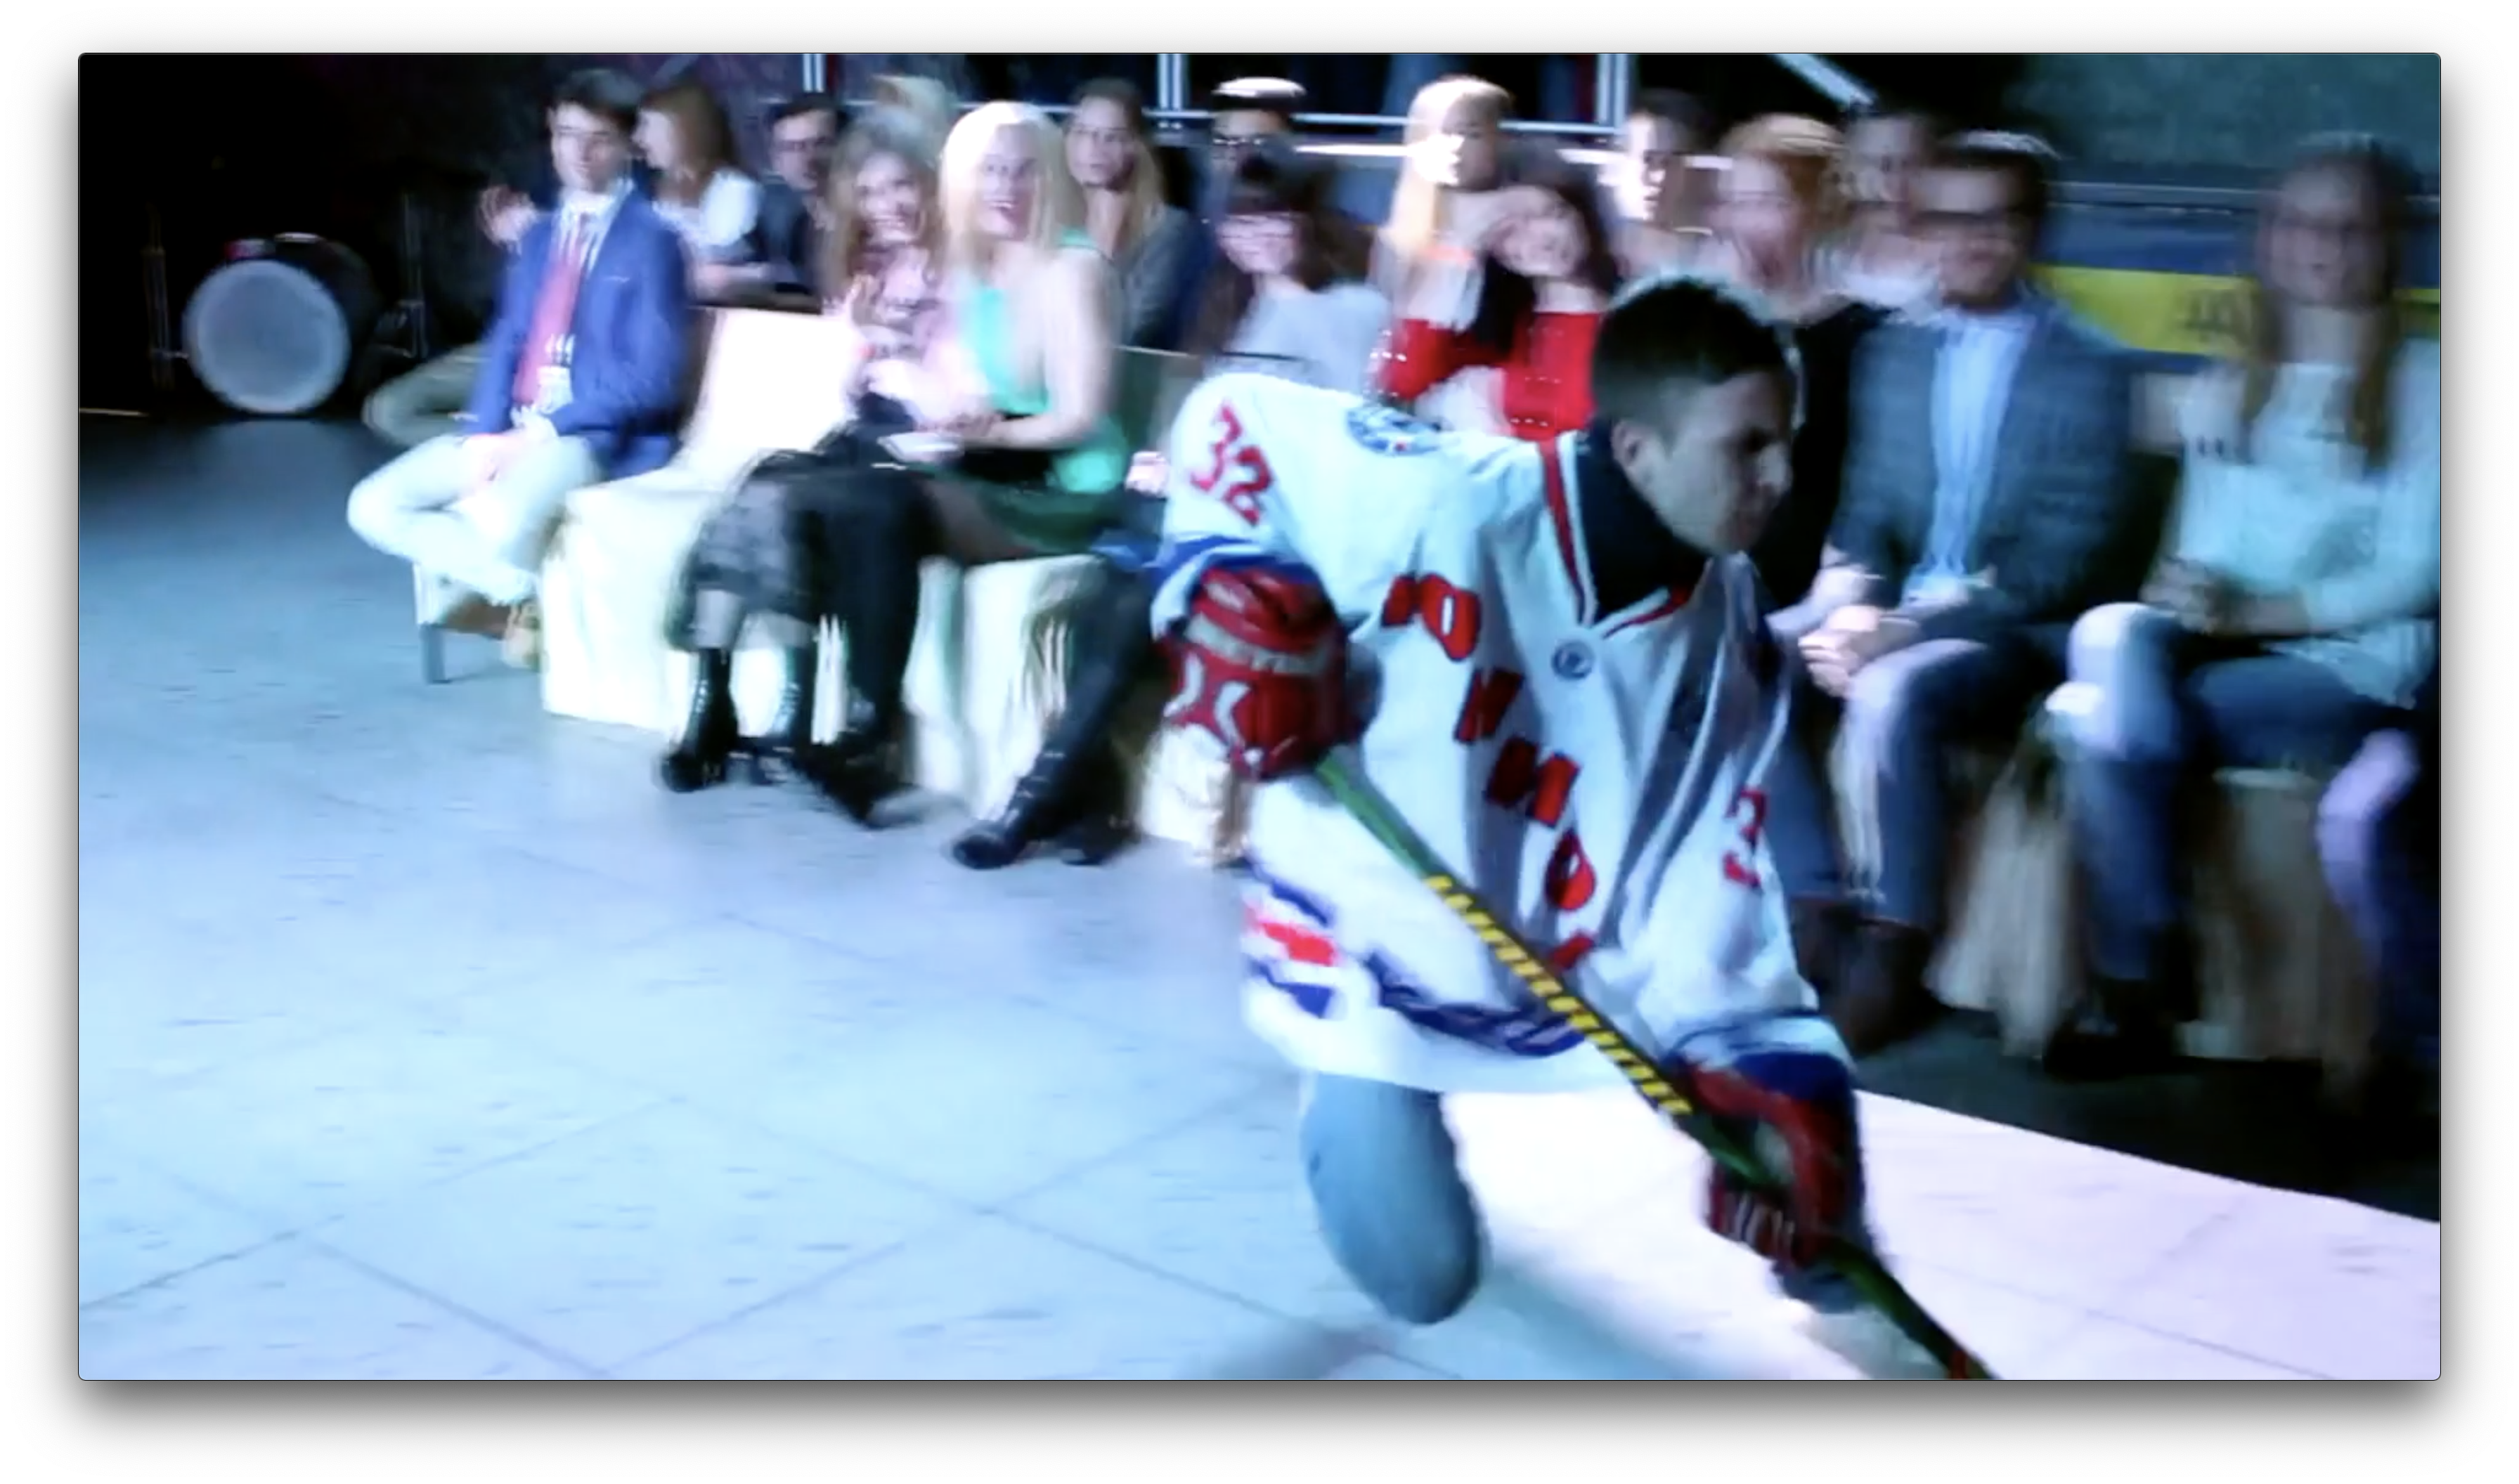

## Полезные ссылки

* https://stackabuse.com/python-for-nlp-topic-modeling/
* https://github.com/RaRe-Technologies/gensim
* http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
* https://github.com/bmabey/pyLDAvis
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/